In [1]:
import numpy as np
import pandas as pd
import kmapper as km
import kneed
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from networkx.readwrite import json_graph
import json
import collections
from dataclasses import dataclass
import ast
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from diskcache import Cache
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
from scipy.stats import wasserstein_distance
import requests
import networkx as nx

sns.set()
cache = Cache('./cachev3/')


In [2]:
NUM_EPOCHS = 176
EPOCH_GAP = 5
LAYERS = [1, 9, 12]

# NUM_EPOCHS = 589
# EPOCH_GAP = 15
# LAYERS = [0, 1, 2]

# NUM_EPOCHS = 74
# EPOCH_GAP = 5
# LAYERS = [1, 9, 12]

DATA = 'train'
DATASET = 'roberta'


In [3]:
@dataclass
class Config:
    iteration: int = 0
    layer: int = 0
    metric: str = 'euclidean'
    filter_func: str = 'l2'
    intervals: int = 50
    overlap: float = 0.5
    min_samples: int = 5


def read_labels(path, dataset='ss-role'):
    label_data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if dataset in ['ss-func', 'ss-role', 'roberta', 'berttiny']:
                word_info, word_label = line.strip().split('\t')
                sent_info, word = word_info.split(':')
                sent_info = ast.literal_eval(sent_info)
                label_data.append([sent_info[0], sent_info[1], word, word_label])
            elif dataset == 'dep':
                word_pair, word_label = line.strip().split('\t')
                word_pair = word_pair.split('--')
                if len(word_pair) == 2:
                    word1, word2 = word_pair
                elif len(word_pair) == 3:
                    word1, word2 = word_pair[0], '--'
                sent_info = [0, 0]
                label_data.append([sent_info[0], sent_info[1], f'{word1}--{word2}', word_label])
            else:
                raise ValueError('Dataset not supported')

    return pd.DataFrame(label_data, columns=['sent_id', 'word_id', 'word', 'label'])


def get_graph(dataset, dist_metric, filter, intervals, overlap, iteration, layer, datasplit, min_samples=3):
    # make request to local server at port 5000 at \graph
    # with the query: {params: 'ss-role_euclidean_l2_50_50', iteration: 0, layer: 12, datasplit: 'train'}
    # and save the response as a variable
    cache_key = f'{dataset}_{dist_metric}_{filter}_{intervals}_{overlap}_{iteration}_{layer}_{datasplit}_{min_samples}'

    if cache_key in cache:
        graph = cache.get(cache_key)
    else:
        r = requests.get(
            'http://localhost:5000/graph',
            params={
                'dataset': dataset,
                'epoch': iteration,
                'layer': layer,
                'dataSplit': datasplit,
                'metric': dist_metric,
                'filter': filter,
                'overlap': overlap,
                'intervals': intervals,
                'minSamples': min_samples,
            })
        # params={'params': f'{dataset}_{dist_metric}_{filter}_{intervals}_{overlap}', 'iteration': iteration, 'layer': layer,
        # 'datasplit': datasplit})
        r.raise_for_status()
        data = r.json()
        graph = nx.json_graph.node_link_graph(data['graph'])
        # graph = data['graph']
        cache[cache_key] = graph

    return graph


def add_node_metadata(graph, metadata_source, activations):
    # create PCA model first
    nodewise_activations = np.vstack([np.mean(activations.iloc[graph['nodes'][node_name]], axis=0) for node_name in graph['nodes']])

    for i, node_name in enumerate(graph['nodes']):
        member_list = graph['nodes'][node_name]

        metadata = [metadata_source.loc[member_index].tolist() for member_index in member_list]
        graph['nodes'][node_name] = {'membership_ids': member_list, 'metadata': metadata,
                                     'l2avg': np.average(metadata_source.loc[member_list]['l2norm']),
                                     'type': 'train'}

    return graph


def elbow_eps(data):
    nbrs = NearestNeighbors(n_neighbors=2).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)[::-1]
    kneedle = kneed.KneeLocator(distances[:, 1], np.linspace(0, 1, num=len(distances)), curve='convex', direction='decreasing')
    eps = kneedle.knee * 0.75 if kneedle.knee else 1
    return eps


def serialize_graph(graph):
    nx_graph = km.adapter.to_networkx(graph)
    js_graph = json_graph.node_link_data(nx_graph)

    for i, node in enumerate(js_graph['nodes']):
        js_graph['nodes'][i]['name'] = js_graph['nodes'][i]['id']
        js_graph['nodes'][i]['l2avg'] = js_graph['nodes'][i]['membership']['l2avg']

    for i, link in enumerate(js_graph['links']):
        id_s = link['source']
        id_t = link['target']
        mem1 = [x['membership']['membership_ids'] for x in js_graph['nodes'] if x['id'] == id_s][0]
        mem2 = [x['membership']['membership_ids'] for x in js_graph['nodes'] if x['id'] == id_t][0]
        mem1, mem2 = set(mem1), set(mem2)
        jaccard = len(mem1.intersection(mem2)) / len(mem1.union(mem2))
        js_graph['links'][i]['intersection'] = jaccard

    return js_graph


def get_mapper(activations, labels, conf):
    labels['l2norm'] = np.expand_dims(np.linalg.norm(activations.to_numpy(), axis=1), 1)
    mapper = km.KeplerMapper()

    if conf.filter_func == 'l1':
        projected_data = np.linalg.norm(activations, ord=1, axis=1).reshape((activations.shape[0], 1))
    elif conf.filter_func == 'l2':
        projected_data = mapper.fit_transform(activations, projection='l2norm')
    elif conf.filter_func == 'knn5':
        projected_data = mapper.fit_transform(activations, projection='knn_distance_5') / 5
    else:
        raise KeyError('Unexpected filter function')

    eps = elbow_eps(activations)
    graph = mapper.map(projected_data, activations, clusterer=DBSCAN(eps=eps, metric=conf.metric, min_samples=conf.min_samples),
                       cover=km.Cover(n_cubes=conf.intervals, perc_overlap=conf.overlap))

    add_node_metadata(graph, labels, activations)

    return serialize_graph(graph)


def node_purity(node, label):
    metadata = node['membership']['metadata']
    label_counts = collections.Counter([x[3] for x in metadata])
    return (label_counts[label], len(metadata), label)


def compute_purities(graph):
    point_node_purities = collections.defaultdict(list)

    for node in graph['nodes']:
        metadata = node['membership']['metadata']

        for i, point_id in enumerate(node['membership']['membership_ids']):
            point_node_purities[point_id].append((i, node_purity(node, metadata[i][3])))

    return point_node_purities


def get_activations_labels(activation_file, label_file):
    activations = pd.read_csv(activation_file, delim_whitespace=True, header=None)
    labels = read_labels(label_file, dataset='dep')
    return activations, labels


def density(X):
    X_score = np.arange(-0.1, 1.1, 0.01)
    # densities = np.exp(KernelDensity(kernel='gaussian', bandwidth=0.001).fit(np.array(X).reshape(-1, 1)).score_samples(X_score.reshape(-1, 1)))
    densities = gaussian_kde(np.array(X)).evaluate(X_score)
    # threshold = 1e-10
    # densities[densities < threshold] = 0
    return densities


In [22]:
def compute_nodewise_purities(graphs, method='entropy'):
    entropy_bound = entropy(np.array([1] * len(labels)) / len(labels))

    def node_purities(graph):
        purities = []
        for node_name, node_data in graph.nodes(data=True):
            n_purity = [0] * len(labels)
            metadata = node_data['memberPoints']
            label_counts = collections.Counter([x['classLabel'] for x in metadata])

            for label, count in label_counts.items():
                n_purity[label_dict[label]] = count / len(metadata)

            if method == 'entropy':
                purities.append(1 - entropy(n_purity) / entropy_bound)
            elif method == 'invclass':
                purities.append(1 / len(label_counts))
            else:
                raise ValueError('Unexpected purity method')

        return purities

    nodewise_purities = []

    for iteration, graph in enumerate(graphs):
        nodewise_purities.append(node_purities(graph))

    df_nodewise_purities = pd.DataFrame([[x * EPOCH_GAP, y] for x, y in enumerate(nodewise_purities)])
    df_nodewise_purities.columns = ['iteration', 'purity']

    return df_nodewise_purities


def compute_pointwise_purities(graphs):

    def point_purities(graph):
        purities = []
        for node_name, node_data in graph.nodes(data=True):
            metadata = node_data['memberPoints']
            label_counts = collections.Counter([x['classLabel'] for x in metadata])


            for mdata in metadata:
                purities.append(label_counts[mdata['classLabel']] / len(metadata))

            # purities.extend([label_counts[label] / len(metadata) for label in labels])
        return purities

    pointwise_purities = []

    for iteration, graph in enumerate(graphs):
        pointwise_purities.append(point_purities(graph))

    df_pointwise_purities = pd.DataFrame([[x * EPOCH_GAP, y] for x, y in enumerate(pointwise_purities)])
    df_pointwise_purities.columns = ['iteration', 'purity']

    return df_pointwise_purities
    return pointwise_purities


def plot_ridge_plots(data_df, title_col, accessor_col, layer, title_text=None, hist=True, purity_type='nodewise_entropy'):
    fig, axes = plt.subplots(nrows=len(data_df), ncols=1, figsize=(8, 15), sharex=True)

    for i, ax in enumerate(axes):
        title = data_df.iloc[i][title_col]
        row_data = data_df.iloc[i][accessor_col]

        if hist:
            sns.histplot(row_data, ax=ax, bins=50)
        else:
            sns.kdeplot(row_data, ax=ax, shade=True, cut=0)

        ax.grid(False)
        ax.set_xlabel('')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylabel(title, rotation=0)
        ax.set_yticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

    if title_text is not None:
        fig.suptitle(title_text)
        plt.tight_layout()

    plt.savefig(f'images/purity_dists_v3/{purity_type}_{DATASET}_layer{layer}_{DATA}{"_hist" if hist else ""}.png', dpi=300)
    plt.close()

    return None


def plot_kljs(purity_df, layer):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    purity_kdes = np.vstack(purity_df.purity.apply(density))

    kl_divs = kl_div(purity_kdes, purity_kdes[0])
    axes[0].plot(np.arange(0, NUM_EPOCHS, EPOCH_GAP), np.sum(kl_divs, axis=1))
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('KL-divergence')
    axes[0].set_title('KL-divergence of purities w.r.t Epoch 0')

    # plt.figure()
    jen_shannon = []
    for i in range(len(purity_kdes)):
        jen_shannon.append(jensenshannon(purity_kdes[0], purity_kdes[i]))

    axes[1].plot(np.arange(0, NUM_EPOCHS, EPOCH_GAP), jen_shannon)
    axes[1].set_xlabel('Batch')
    axes[1].set_ylabel('Jensen-Shannon')
    axes[1].set_title('Jensen-Shannon distance of purities w.r.t Epoch 0')

    plt.savefig(f'images/purity_dists_v3/kl_js_distances_{DATASET}_layer{layer}_{DATA}.png', dpi=300)
    plt.close()

    return None


def plot_kljs_labelled(purity_dfs, plot_labels, axes):
    # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    kl_divs_computed = []
    jen_shannon_computed = []
    earth_mover_computed = []

    for purity_df, label in zip(purity_dfs, plot_labels):
        purity_kdes = np.vstack(purity_df.purity.apply(density))

        kl_divs = kl_div(purity_kdes, purity_kdes[0])
        kl_divs_computed.append(np.sum(kl_divs, axis=1))

        jen_shannon = []

        for i in range(len(purity_kdes)):
            jen_shannon.append(jensenshannon(purity_kdes[0], purity_kdes[i]))

        earth_mover = []
        for i in range(len(purity_kdes)):
            earth_mover.append(wasserstein_distance(purity_kdes[0], purity_kdes[i]))

        jen_shannon_computed.append(jen_shannon)
        earth_mover_computed.append(earth_mover)

        axes[0].plot(np.arange(0, NUM_EPOCHS, EPOCH_GAP), np.sum(kl_divs, axis=1), label=label)
        axes[1].plot(np.arange(0, NUM_EPOCHS, EPOCH_GAP), jen_shannon, label=label)
        axes[2].plot(np.arange(0, NUM_EPOCHS, EPOCH_GAP), earth_mover, label=label)

    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('KL-divergence')
    axes[0].set_title('KL-divergence of purities w.r.t Epoch 0')
    axes[0].legend()

    axes[1].set_xlabel('Batch')
    axes[1].set_ylabel('Jensen-Shannon distance')
    axes[1].set_title('Jensen-Shannon distance of purities w.r.t Epoch 0')
    axes[1].legend()

    axes[2].set_xlabel('Batch')
    axes[2].set_ylabel('Earth Mover Distance')
    axes[2].set_title('Earth Mover Distance of purities w.r.t Epoch 0')
    axes[2].legend()

    return kl_divs_computed, jen_shannon_computed, earth_mover_computed


In [17]:
for layer in LAYERS:
    graphs = []

    for fileindex in tqdm(range(0, NUM_EPOCHS, EPOCH_GAP)):
        # config = Config(iteration=fileindex, layer=layer, metric='euclidean', filter_func='l2', intervals=50, overlap=0.5, min_samples=3)
        # graphs.append(get_graph(config, caching=True))
        graph = get_graph(DATASET, 'euclidean', 'l2', 50, 50, fileindex, layer, 'train', min_samples=3)
        graphs.append(graph)

    labels = sorted(read_labels(f'../backend/data/{DATASET}/entities/{DATA}.txt', dataset=DATASET).label.unique().tolist())

    # convert label to dict with positions as value
    label_dict = {label: i for i, label in enumerate(labels)}

    nodewise_purities = compute_nodewise_purities(graphs, method='entropy')
    plot_ridge_plots(nodewise_purities, 'iteration', 'purity', layer, title_text=f'Layer {layer}', hist=False)
    # plot_kljs(nodewise_purities, layer)


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Change in purity distribution w.r.t. Epoch 0


In [18]:
purity_dfs = []
plot_labels = []

# fine_tuning_accs = pd.read_csv(f'../backend/data/Fine-tuning-accs/{DATASET}.csv', index_col=0)
# accuracies = fine_tuning_accs.iloc[-1, :]
# accuracies = accuracies.to_list()[:-1]
# accuracies = [float(acc) for acc in accuracies]

for layer in LAYERS:
    graphs = []

    for fileindex in tqdm(range(0, NUM_EPOCHS, EPOCH_GAP)):
        config = Config(iteration=fileindex, layer=layer, metric='euclidean', filter_func='l2', intervals=50, overlap=0.5, min_samples=3)
        graph = get_graph(DATASET, 'euclidean', 'l2', 50, 50, fileindex, layer, 'train', min_samples=3)
        graphs.append(graph)

    labels = sorted(read_labels(f'../backend/data/{DATASET}/entities/{DATA}.txt').label.unique().tolist())
    # convert label to dict with positions as value
    label_dict = {label: i for i, label in enumerate(labels)}

    nodewise_purities = compute_nodewise_purities(graphs, method='entropy')

    purity_dfs.append(nodewise_purities)
    plot_labels.append(f'Layer {layer}')


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

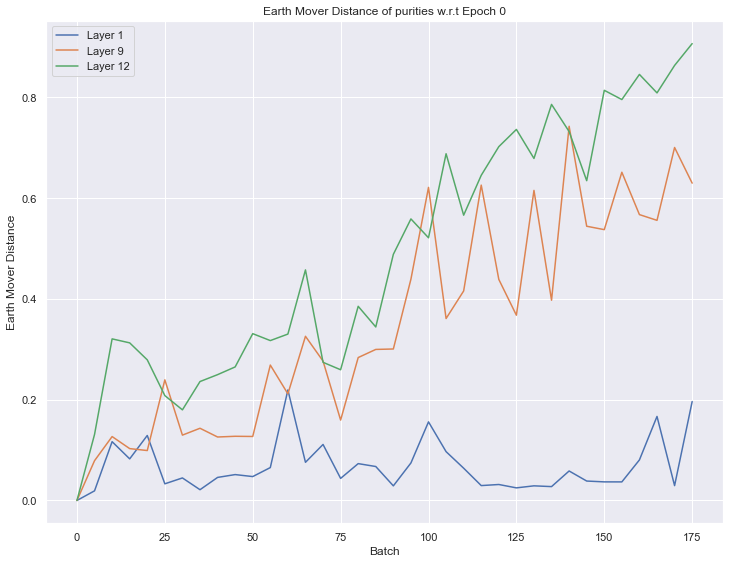

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))
kl_divs, jen_shannons, earth_movers = plot_kljs_labelled(purity_dfs, plot_labels, axes)

axes[0].remove()
axes[1].remove()

fig.tight_layout()

plt.savefig(f'images/kljs/emd_distances_{DATASET}_{DATA}.png', dpi=300, bbox_inches='tight')



### Correlation between KLJS distances and test accuracy


In [20]:
for layer, kl in zip(LAYERS, kl_divs):
    print(f'Layer {layer}:\t Corr(Accuracy, KL) = {np.corrcoef(accuracies, kl)[0, 1]:.3f}')

print()

for layer, js in zip(LAYERS, jen_shannons):
    print(f'Layer {layer}:\t Corr(Accuracy, JS) = {np.corrcoef(accuracies, js)[0, 1]:.3f}')
    

Layer 1:	 Corr(Accuracy, KL) = 0.088
Layer 9:	 Corr(Accuracy, KL) = 0.674
Layer 12:	 Corr(Accuracy, KL) = 0.659

Layer 1:	 Corr(Accuracy, JS) = 0.135
Layer 9:	 Corr(Accuracy, JS) = 0.720
Layer 12:	 Corr(Accuracy, JS) = 0.678


  0%|          | 0/36 [00:00<?, ?it/s]

Layer 1:	 Corr(Accuracy, Avg-Purity) = 0.258


  0%|          | 0/36 [00:00<?, ?it/s]

Layer 9:	 Corr(Accuracy, Avg-Purity) = 0.719


  0%|          | 0/36 [00:00<?, ?it/s]

Layer 12:	 Corr(Accuracy, Avg-Purity) = 0.692


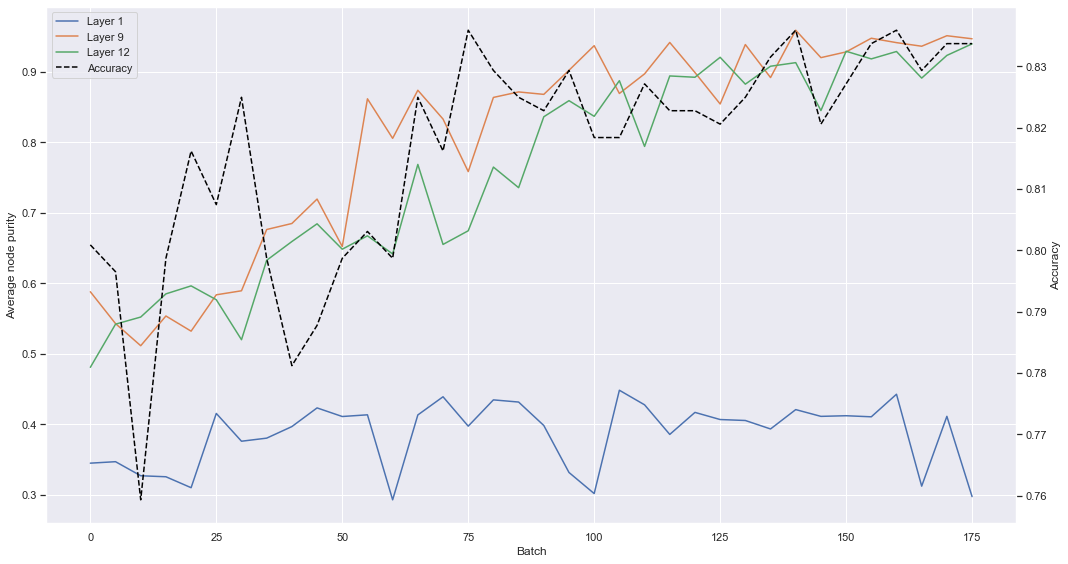

In [23]:
fine_tuning_accs = pd.read_csv(f'../backend/data/Fine-tuning-accs/{DATASET}.csv', index_col=0)
accuracies = fine_tuning_accs.iloc[-1, :]
accuracies = accuracies.to_list()[:-1]
accuracies = [float(acc) for acc in accuracies]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

ax.set_xlabel('Batch')
ax.set_ylabel('Average node purity')

corrs = []

for layer in [1, 9, 12]:
    graphs = []

    for fileindex in tqdm(range(0, NUM_EPOCHS, EPOCH_GAP)):
        graph = get_graph(DATASET, 'euclidean', 'l2', 50, 50, fileindex, layer, 'train', min_samples=3)
        graphs.append(graph)

    labels = sorted(read_labels(f'../backend/data/{DATASET}/entities/{DATA}.txt').label.unique().tolist())
    # convert label to dict with positions as value
    label_dict = {label: i for i, label in enumerate(labels)}

    # nodewise_purities = compute_nodewise_purities(graphs, method='entropy')
    nodewise_purities = compute_pointwise_purities(graphs)

    average_purity = nodewise_purities.purity.apply(lambda x: np.mean(x))

    print(f'Layer {layer}:\t Corr(Accuracy, Avg-Purity) = {np.corrcoef(accuracies, average_purity)[0, 1]:.3f}')
    corrs.append([f'Layer {layer}', np.corrcoef(accuracies, average_purity)[0, 1]])

    ax.plot(np.arange(0, NUM_EPOCHS, EPOCH_GAP), average_purity, label=f'Layer {layer}')

ax_acc = ax.twinx()
ax_acc.plot(np.arange(0, NUM_EPOCHS, EPOCH_GAP), accuracies, linestyle='--', color='black', label='Accuracy')
ax_acc.set_ylabel('Accuracy')
# ax_acc.legend(loc='upper left')
ax_acc.grid(False)
# ax_acc.set_ylim(0.5, 1)

# ax.legend()

handles, labels = ax.get_legend_handles_labels()
handles_acc, labels_acc = ax_acc.get_legend_handles_labels()
handles_combined, labels_combined = handles + handles_acc, labels + labels_acc
ax.legend(handles_combined, labels_combined, loc='upper left')

plt.tight_layout()

plt.savefig(f'images/average_purity_vs_accuracy/avg_purity_vs_acc_{DATASET}_{DATA}.png', dpi=300)


In [24]:
corr_df = pd.DataFrame(corrs, columns=['Layer', 'Correlation'])
corr_df.Correlation = corr_df.Correlation.apply(lambda x: round(x, 3))
corr_df


,Layer,Correlation
0,Layer 1,0.258
1,Layer 9,0.719
2,Layer 12,0.692


In [6]:
for layer in LAYERS:
    graphs = []

    for fileindex in tqdm(range(0, NUM_EPOCHS, EPOCH_GAP)):
        config = Config(iteration=fileindex, layer=layer, metric='euclidean', filter_func='l2', intervals=50, overlap=0.5, min_samples=3)
        graphs.append(get_graph(config, caching=True))

    labels = sorted(read_labels(f'../backend/data/{DATASET}/entities/{DATA}.txt').label.unique().tolist())
    # convert label to dict with positions as value
    label_dict = {label: i for i, label in enumerate(labels)}

    # nodewise_purities = compute_nodewise_purities(graphs, method='entropy')
    nodewise_purities = compute_pointwise_purities(graphs)

    plot_ridge_plots(nodewise_purities, 'iteration', 'purity', layer, title_text=f'Layer {layer}', hist=False, purity_type='pointwise')


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

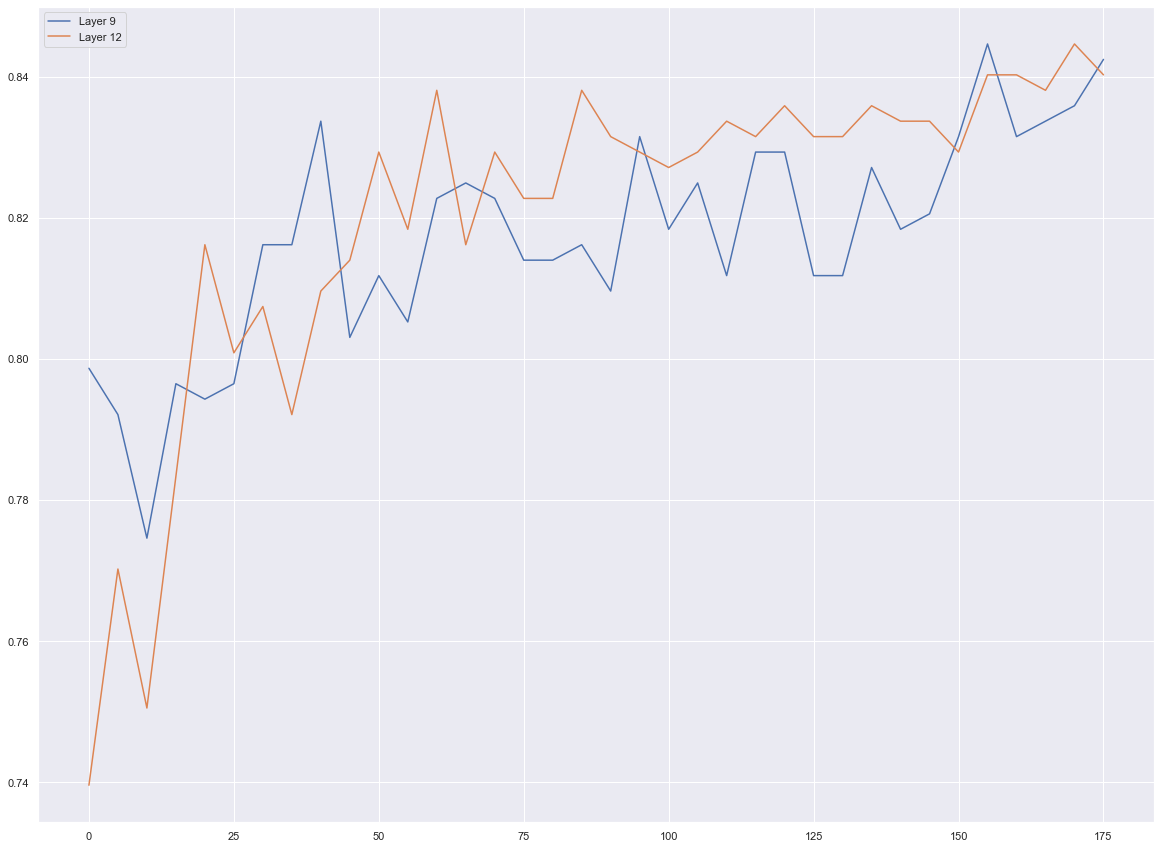

In [52]:
layerwise_dataset = 'ss-role'
# layerwise_dataset = 'roberta'

plt.figure(figsize=(20, 15))
# Layerwise accuracies
for layer in [9, 12]:
    accuracies = pd.read_csv(f'../backend/data/Fine-tuning-accs-layerwise/{layerwise_dataset}/layer-{layer}.csv', index_col=0)
    accuracies = accuracies.iloc[-1, :]
    accuracies = accuracies.to_list()[:-1]
    accuracies = [float(acc) for acc in accuracies]
    plt.plot(np.arange(0, NUM_EPOCHS, EPOCH_GAP), accuracies, label=f'Layer {layer}')
    plt.legend(loc='upper left')
    plt.savefig(f'images/kljs/layerwise_accuracies_{layerwise_dataset}_{DATA}.png', dpi=300)
